# Monte o seu Drive
Necessário para acessar os dados no Drive Compartilhado.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Install DLPT
This is a packaging of my Deep Learning code, reused in multiple projects.
To check its code, check the .tar file that is on the repository. Do not distribute as it has unpublished code.


In [ ]:
!git clone https://github.com/dscarmo/IA368X_Diedre_Joany_Leard
!cp -r IA368X_Diedre_Joany_Leard/* .
!rm -rfd IA368X_Diedre_Joany_Leard
!python3 -m pip install dlpt_installer/DLPT-0.0.1-py3-none-any.whl --quiet

Cloning into 'IA368X_Diedre_Joany_Leard'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 200 (delta 83), reused 137 (delta 46), pack-reused 0
Receiving objects: 100% (200/200), 18.69 MiB | 15.38 MiB/s, done.
Resolving deltas: 100% (83/83), done.


# Imports and Initial Configurations
Imports needes libraries and code. 

In [ ]:
'''
Experiment Description
CNN3DAtt: Try to use convolutional layers followed by CNNs and fully connected layers for survival regression
'''
EXPERIMENT_NAME = "CNN3DAtt"

# Standard Library
import os
import logging
import sys
import pickle
import argparse
import random
import time
from glob import glob
from multiprocessing import cpu_count

# External Libraries
import numpy as np
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import Adam
from sklearn.metrics import accuracy_score, mean_squared_error

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# DLPT (Deep Learning with PyTorch)
from DLPT.models.cnn3d_att import CNN3DAtt
from DLPT.optimizers.radam import RAdam
from DLPT.transforms.to_tensor import ToTensor
from DLPT.transforms.patches import ReturnPatch, CenterCrop
from DLPT.transforms.intensity import RandomIntensity
from DLPT.transforms import Compose
from DLPT.datasets.brats import BRATS
from DLPT.utils.git import get_git_hash
from DLPT.utils.reproducible import deterministic_run



Configurar acesso aos dados no Drive

In [ ]:
DATA_PATH = "/content/drive/Shared drives/DadosIA369X/2020/train"

assert os.path.isdir(DATA_PATH), f"Não encontrei pasta de dados: {DATA_PATH}. Tem certeza que montou o drive? Rode a primeira célula!"

BRATS.PATHS["2020"]["default"] = DATA_PATH

# Configurar Paths e Transformadas
Parâmetros fixos dos experimentos, localização onde salvar os pesos dos modelos e os logs do MLflow. SmoothL1Loss como Loss e transformadas com parâmetros fixos.


In [ ]:
model_folder = "models"
log_folder = "mlruns"
os.makedirs(log_folder, exist_ok=True)

loss_calculator = nn.SmoothL1Loss()

transforms = Compose([ReturnPatch(patch_size=(128, 128, 128), segmentation=True, fullrandom=True,
                                  reset_seed=False), RandomIntensity(reset_seed=False),
                      ToTensor(volumetric=True, classify=False)])
test_transforms = Compose([CenterCrop(128, 128, 128, segmentation=True, assert_big_enough=True),
                           ToTensor(volumetric=True, classify=False)])

# Argumentos do Experimento
Aqui o arquivo argument_parser.py é utilizado para criar o arquivo de hiperparametros utilizado pelo PyTorch Lightning

In [ ]:
!python3 src/cnn_argument_parser.py best_longer -bs 3 -lr 0.00005 -opt RAdam -precision 32 -channel_factor 1 -max_epochs 600

with open("hparams.pkl", 'rb') as hp:
    hyperparameters = pickle.load(hp)

hyperparameters.loss = loss_calculator.__class__.__name__
hyperparameters.transforms = str(transforms)
hyperparameters.test_transforms = str(test_transforms)
print("Hyperparameters:")
vars(hyperparameters)

Hyperparameters:


{'bs': 3,
 'channel_factor': 1.0,
 'dataset': 'BRATS',
 'dataset_year': '2020',
 'debug': False,
 'desc': 'best_longer',
 'fold': 'None',
 'forced_overfit': 0,
 'kfold': 'None',
 'loss': 'SmoothL1Loss',
 'lr': 5e-05,
 'max_epochs': 600,
 'nin': 7,
 'nout': 1,
 'opt': 'RAdam',
 'precision': 32,
 'rseed': 4321,
 'splits': '(0.7, 0.1, 0.2)',
 'test_bs': 1,
 'test_transforms': 'CenterCrop, patch size: 128x128x128 volumetric True segmentation True ToTensor: volumetric True, classify: False',
 'transforms': 'ReturnPatch: ppositive 0.8 patch_size (128, 128, 128), kernel_shape (3, 3), volumetric True, anyborder False Intensity: p 1, brightness 0.1 ToTensor: volumetric True, classify: False',
 'wd': 1e-05}

# Lightning Module
Este módulo define praticamente tudo necessário para o treino de uma CNN. Para explicações detalhadas, consulte https://pytorch-lightning.readthedocs.io/en/latest/.

In [ ]:
class CNN3DAttSurvival(pl.LightningModule):
    SURVIVAL_CLASSES = ["short survivor", "mid survivor", "long survivor"]
    def __init__(self, hparams):
        super().__init__()

        self.hparams = hparams
        self.model = CNN3DAtt(self.hparams.nin, self.hparams.nout, channel_factor=self.hparams.channel_factor, limit_output=[0, 2000], survival_regression=True)

    def forward(self, x):
        return self.model(x)
    
    def regularize_meta_data(self, tumor_type, age, survival):
        return tumor_type.float().unsqueeze(-1), age.float().unsqueeze(-1), survival.float()

    def training_step(self, batch, batch_idx):
        '''
        Training
        '''
        x, y, tumor_type, age, survival = batch
        tumor_type, age, survival = self.regularize_meta_data(tumor_type, age, survival)
        survival = survival
        x = torch.cat((x, y), dim=1)
        y_hat = self.forward((x, tumor_type, age))
        loss = loss_calculator(y_hat, survival)  

        tensorboard_logs = {'loss': loss}

        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        '''
        Validation step.
        '''
        x, y, tumor_type, age, survival = batch
        tumor_type, age, survival = self.regularize_meta_data(tumor_type, age, survival)
        survival = survival
        x = torch.cat((x, y), dim=1)
        y_hat = self.forward((x, tumor_type, age))
        loss = loss_calculator(y_hat, survival)  

        return {'loss': loss}

    def test_step(self, batch, batch_idx):
        '''
        Test. Should be exactly equal to validation step
        '''
        x, y, tumor_type, age, survival = batch
        tumor_type, age, survival = self.regularize_meta_data(tumor_type, age, survival)
        survival = survival
        x = torch.cat((x, y), dim=1)
        y_hat = self.forward((x, tumor_type, age))
        loss = loss_calculator(y_hat, survival) 

        return {'loss': loss}

    # -----------------------------------------------------------------------------------------------------------------#

    def training_epoch_end(self, outputs):
        '''
        Training
        '''
        name = "train_"

        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()

        return {'log': {name + 'loss': avg_loss}}

    def validation_epoch_end(self, outputs):
        '''
        Validation
        '''
        name = "val_"

        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()

        return {'log': {name + 'loss': avg_loss}}

    def test_epoch_end(self, outputs):
        '''
        Test
        '''
        name = "test_"

        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()

        return {'log': {name + 'loss': avg_loss}}

    # -----------------------------------------------------------------------------------------------------------------#

    def configure_optimizers(self):
        if self.hparams.opt == "Adam":
            opt = Adam(self.model.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.wd)
        elif self.hparams.opt == "RAdam":
            opt = RAdam(self.model.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.wd)

        assert self.hparams.opt == opt.__class__.__name__

        return [opt], [torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.985)]

    def train_dataloader(self):
        dataset = BRATS(year=self.hparams.dataset_year, release="default", group="all", mode="train",
                        transform=transforms, convert_to_eval_format=True, has_survival_only=True)
        return dataset.get_dataloader(batch_size=self.hparams.bs, shuffle=True, num_workers=cpu_count()//2)

    def val_dataloader(self):
        dataset = BRATS(year=self.hparams.dataset_year, release="default", group="all", mode="validation",
                        transform=test_transforms, convert_to_eval_format=True, has_survival_only=True)
        return dataset.get_dataloader(batch_size=self.hparams.test_bs, shuffle=False, num_workers=cpu_count()//2)

    def test_dataloader(self):
        dataset = BRATS(year=self.hparams.dataset_year, release="default", group="all", mode="test",
                        transform=test_transforms, convert_to_eval_format=True, has_survival_only=True)
        return dataset.get_dataloader(batch_size=self.hparams.test_bs, shuffle=False, num_workers=cpu_count()//2)


# # Initialize Trainer
# Instantiate model
model = CNN3DAttSurvival(hyperparameters)

# Folder management
experiment_name = EXPERIMENT_NAME
os.makedirs(model_folder, exist_ok=True)
ckpt_path = os.path.join(model_folder, "-{epoch}-{val_loss:.4f}")

# Callback initialization
checkpoint_callback = ModelCheckpoint(prefix=experiment_name + '_' + hyperparameters.desc, filepath=ckpt_path, monitor="val_loss",
                                      mode="min")
logger = MLFlowLogger(experiment_name=experiment_name, tracking_uri="file:" + log_folder,
                      tags={"desc": hyperparameters.desc, "commit": get_git_hash()})

# PL Trainer initialization
trainer = Trainer(gpus=1, precision=hyperparameters.precision, checkpoint_callback=checkpoint_callback,
                  early_stop_callback=False, logger=logger, max_epochs=hyperparameters.max_epochs,
                  fast_dev_run=hyperparameters.debug, progress_bar_refresh_rate=1, overfit_batches=hyperparameters.forced_overfit)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


# Treinar
Aqui o loop de treinamento é executado. A GPU do Colab provavelmente não vai suportar rodar o loop inteiro, seria necessário conectar a um kernel Jupyter local.

In [ ]:
# # Training Loop
seed = hyperparameters.rseed
print(f"Applying random seed {seed}")
deterministic_run(seed)
trainer.fit(model)

# Avaliação do melhor modelo
Aqui o melhor modelo em termos de mínimo de perda validação, é avaliado com métricas de classificação e MSE. 

## Carregar o melhor modelo

In [ ]:
best_model_path = "models/best_model.ckpt"

# Loading best model
model = CNN3DAttSurvival.load_from_checkpoint(best_model_path)
model = model.cuda()
model = model.eval()

## Funções auxiliares
Algumas funções para ajudar no tratamento dos valores de sobrevivência e cállculo das métricas.


In [ ]:
def survival_to_class(survival):
    classes = np.zeros_like(survival)

    classes[survival < 300] = CNN3DAttSurvival.SURVIVAL_CLASSES.index("short survivor")
    classes[survival >= 300] = CNN3DAttSurvival.SURVIVAL_CLASSES.index("mid survivor")
    classes[survival >= 450] = CNN3DAttSurvival.SURVIVAL_CLASSES.index("long survivor")

    return classes

def survival_accuracy(y_true, y_pred):
    true_class = survival_to_class(y_true).astype(np.long)
    pred_class = survival_to_class(y_pred).astype(np.long)

    print(f"True class: {true_class}")
    print(f"Pred class: {pred_class}")

    return accuracy_score(true_class, pred_class)

def survival_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def predict(model, batch):
    with torch.set_grad_enabled(False):
        x, y, tumor_type, age, survival = batch
        tumor_type, age, survival = model.regularize_meta_data(tumor_type, age, survival)
        x = torch.cat((x, y), dim=1)
        y_hat = model.forward((x, tumor_type, age))
        
    return y_hat, survival

def min_max_norm_att(atts):
    ret_atts = []
    for att in atts:
        norm_att = att.squeeze()
        norm_att = (norm_att - norm_att.min())/(norm_att.max() - norm_att.min())
        ret_atts.append(norm_att)
        
    return ret_atts

## Analisar dados de Validação com melhor modelo




In [ ]:
val_dataloader = iter(model.val_dataloader())

y_preds = []
ys = []

for batch in tqdm(val_dataloader, desc="Extracting val metrics..."):
    batch = (x.cuda() for x in batch)
    y_pred, y = predict(model, batch)

    y_preds.append(int(y_pred.item()))
    ys.append(int(y.item()))
time.sleep(1)

y_preds = np.array(y_preds)
ys = np.array(ys)

Extracting val metrics...: 100%|██████████| 21/21 [01:29<00:00,  4.25s/it]


In [ ]:
mse = survival_mse(ys, y_preds)
acc = survival_accuracy(ys, y_preds)

print(f"Val Predictions: {y_preds}")
print(f"Val Targets    : {ys}")
print(f"Val MSE: {mse}")
print(f"Val ACC: {acc}")

True class: [1 1 0 0 2 2 0 2 2 0 0 2 0 0 0 2 2 0 0 2 1]
Pred class: [1 1 2 0 1 2 0 2 0 0 0 0 0 0 0 2 2 0 2 0 0]
Val Predictions: [ 430  318  603   59  393  464  229 1101  239  187  209  234   83  294
  116  604  465  184  563  113  287]
Val Targets    : [ 359  334  199   21  466  600  127 1767  730  120  170 1096   85  103
  121  495 1227  239  268  468  336]
Val MSE: 118351.80952380953
Val ACC: 0.6666666666666666


## Analisar dados de Teste com melhor modelo

In [ ]:
test_dataloader = iter(model.test_dataloader())

t_y_preds = []
t_ys = []

for batch in tqdm(test_dataloader, desc="Extracting test metrics..."):
    batch = (x.cuda() for x in batch)
    y_pred, y = predict(model, batch)

    t_y_preds.append(int(y_pred.item()))
    t_ys.append(int(y.item()))
time.sleep(1)

t_y_preds = np.array(t_y_preds)
t_ys = np.array(t_ys)

Extracting test metrics...: 100%|██████████| 46/46 [03:11<00:00,  4.17s/it]


In [ ]:
t_mse = survival_mse(t_ys, t_y_preds)
t_acc = survival_accuracy(t_ys, t_y_preds)

print(f"Test Predictions: {t_y_preds}")
print(f"Test Targets    : {t_ys}")
print(f"Test MSE: {t_mse}")
print(f"Test ACC: {t_acc}")

True class: [2 2 1 1 0 1 2 1 0 2 1 2 2 2 2 0 0 0 0 2 2 0 2 2 1 1 2 1 2 2 1 1 2 2 0 2 0
 0 0 1 0 1 0 0 2 0]
Pred class: [0 0 0 0 1 2 1 0 1 2 2 1 2 2 2 0 0 0 0 2 2 0 0 0 0 1 0 0 2 0 0 1 2 1 0 2 0
 0 0 2 0 1 0 0 0 0]
Test Predictions: [ 159  244  189  267  323  753  445  175  303  512  544  347  550  474
  647  154  157  150   83  867 1020   70  161  239   77  377  268  211
  767  116  260  344  492  334  274  572   97  114   87  611  140  433
  125  159  189  140]
Test Targets    : [ 580  488  332  322  208  407  728  355  250 1731  405  558 1283 1410
  822   89  208   82   82  903  630  277  684  634  409  319  635  387
  788  476  436  372 1282 1076  175  524   82  106   56  350  260  385
  262  146  473   32]
Test MSE: 129667.58695652174
Test ACC: 0.5434782608695652


## Visualização de Atenção


### Recarregar o melhor modelo

In [ ]:
best_model_path = "models/best_model.ckpt"

# Loading best model
model = CNN3DAttSurvival.load_from_checkpoint(best_model_path)
model = model.cuda()
model = model.eval()

### Gerar predição

In [ ]:
subject = next(iter(model.test_dataloader()))
y_pred, y = predict(model, (x.cuda() for x in subject))

### Extrair mapas de atenção

In [ ]:
atts = model.model.return_atts()

Computing zooms...: 100%|██████████| 1/1 [00:00<00:00, 1185.50it/s]


In [ ]:
normed_atts = min_max_norm_att(atts)

### Carregar MRI para visualização

In [ ]:
subject_np = subject[0].numpy().squeeze()

### Visualizar
Os mapas de atenção são extraidos e visualizados junto com a mesma fatia das entradas.


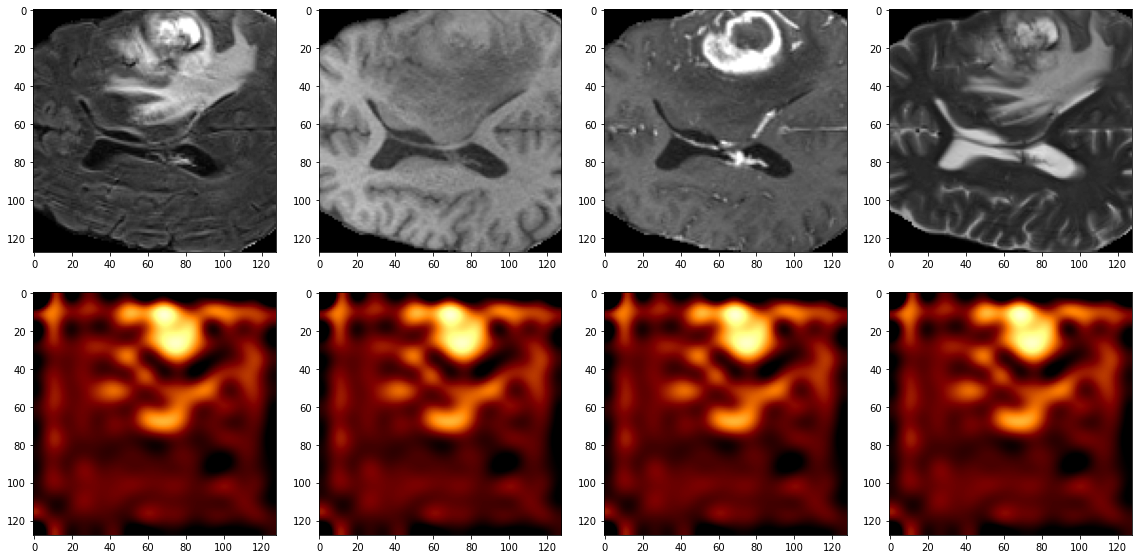

In [ ]:
#@title Selecione qual fatia para visualizar:
s =  70#@param {type: "integer"}

def view(s):
    plt.figure(figsize=(16, 8))
    for i in range(4):
        plt.subplot(2, 4, i + 1)
        plt.imshow(subject_np[i, :, :, s], cmap="gray", vmin=0.0, vmax=1.0)

    for i in range(4):
        plt.subplot(2, 4, 5 + i)
        plt.imshow(normed_atts[0][:, :, s], cmap="afmhot", vmin=0.8, vmax=1.0)
    plt.tight_layout()
    plt.savefig("att.png")
    plt.show()
    
view(s)